**Import Modules**

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

**Read Data**

In [2]:
# Load the training data
train_path = r'D:\project 1\Genre Classification Dataset\train_data.txt'
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [3]:
print(train_data.describe())

                                 Title    Genre  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  


In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None


In [5]:
print(train_data.isnull().sum())

Title          0
Genre          0
Description    0
dtype: int64


In [6]:
# Load the test data
test_path = r'D:\project 1\Genre Classification Dataset\test_data.txt'
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


**Visualization**

C:\Users\sinek\AppData\Local\Temp\ipykernel_16716\431713057.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_data['Genre'], order=train_data['Genre'].value_counts().index, palette='coolwarm')


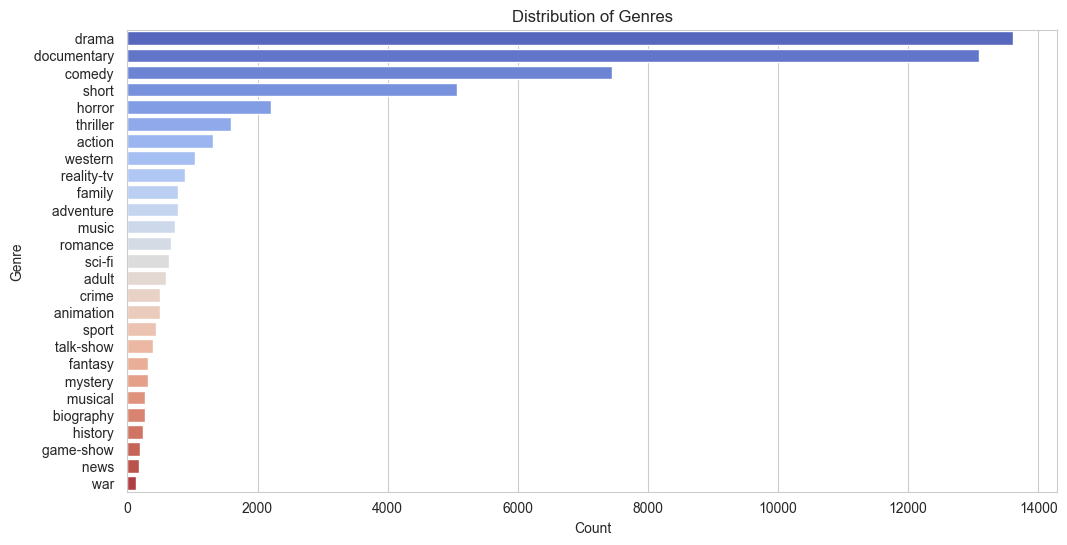

In [7]:
# Genre Distribution with a different color palette and plot style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.countplot(y=train_data['Genre'], order=train_data['Genre'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

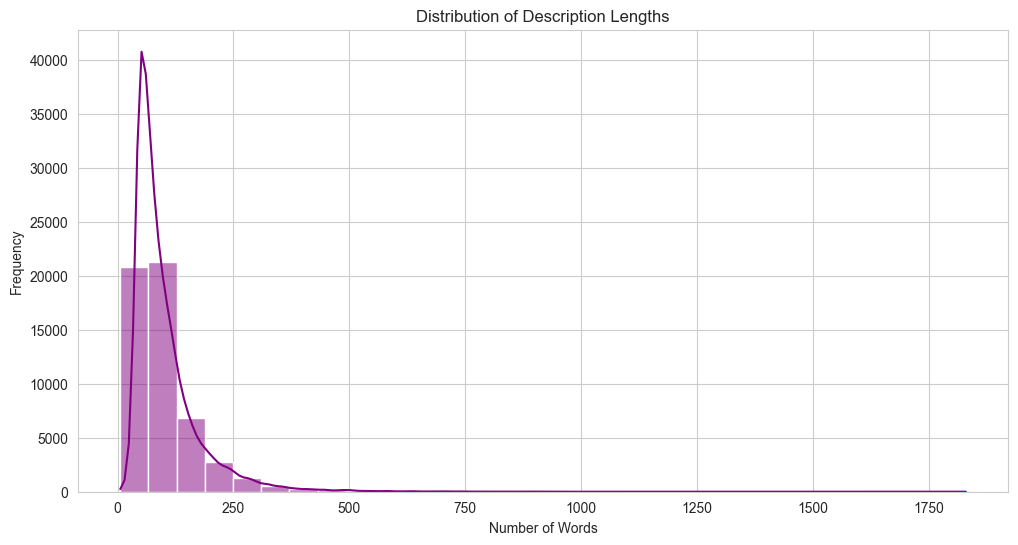

In [8]:
#  Description Length Analysis
train_data['Description_Length'] = train_data['Description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(train_data['Description_Length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Description Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

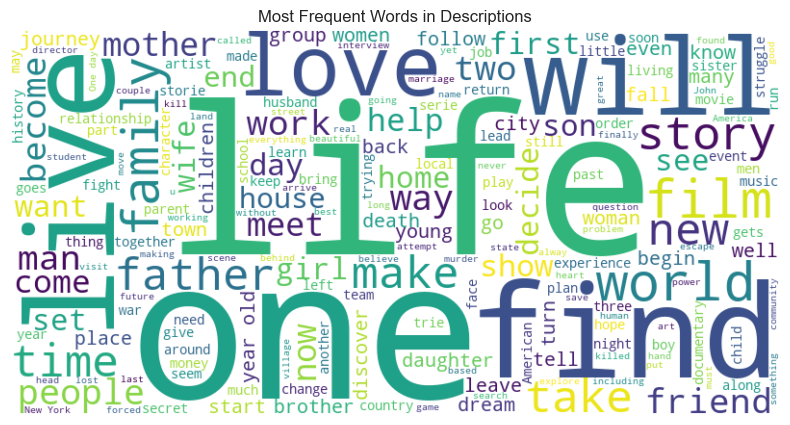

In [9]:
#  Word Cloud
all_descriptions = ' '.join(train_data['Description'].dropna())
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Descriptions')
plt.show()

**Preprocessing**

In [10]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sinek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [12]:
# Apply preprocessing to the training data
train_data['cleaned_description'] = train_data['Description'].apply(preprocess_text)

In [13]:
# Apply preprocessing to the test data
test_data['cleaned_description'] = test_data['Description'].apply(preprocess_text)

In [14]:
# Check the cleaned text
print(train_data[['Description', 'cleaned_description']].head())

                                         Description  \
1   Listening in to a conversation between his do...   
2   A brother and sister with a past incestuous r...   
3   As the bus empties the students for their fie...   
4   To help their unemployed father make ends mee...   
5   The film's title refers not only to the un-re...   

                                 cleaned_description  
1  listening conversation doctor parent yearold o...  
2  brother sister past incestuous relationship cu...  
3  bus empty student field trip museum natural hi...  
4  help unemployed father make end meet edith twi...  
5  film title refers unrecovered body ground zero...  


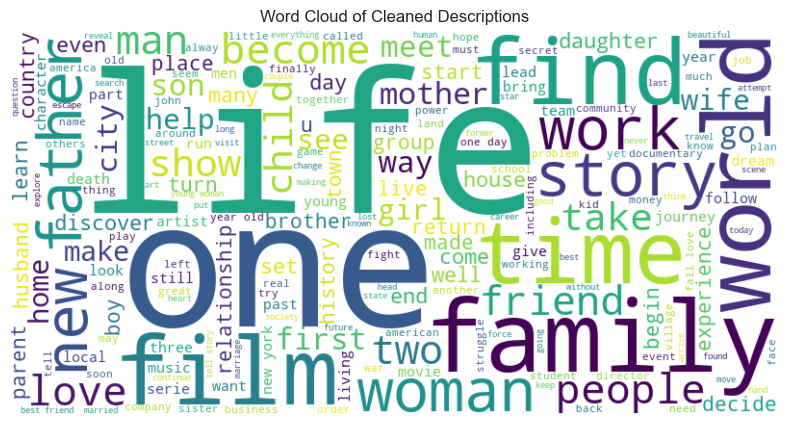

In [15]:
# Combine all cleaned descriptions into a single string
all_cleaned_descriptions = ' '.join(train_data['cleaned_description'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_cleaned_descriptions)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Descriptions')
plt.show()

**Text Vectorization**

In [16]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_description'])

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_description'])

# Display the shape of the transformed data
print("Shape of training data:", X_train_tfidf.shape)
print("Shape of test data:", X_test_tfidf.shape)

Shape of training data: (54214, 5000)
Shape of test data: (54200, 5000)


**Data Splitting**

In [17]:
y = train_data['Genre']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val)

In [18]:
# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.5767776445633127
Validation Classification Report:
                precision    recall  f1-score   support

      action        0.49      0.27      0.35       263
       adult        0.74      0.31      0.44       118
   adventure        0.57      0.13      0.21       155
   animation        0.48      0.10      0.17       100
   biography        0.00      0.00      0.00        53
      comedy        0.53      0.59      0.56      1490
       crime        0.08      0.01      0.02       101
 documentary        0.66      0.84      0.74      2619
       drama        0.54      0.76      0.63      2723
      family        0.56      0.10      0.16       157
     fantasy        0.00      0.00      0.00        65
   game-show        0.90      0.46      0.61        39
     history        0.00      0.00      0.00        49
      horror        0.65      0.57      0.61       441
       music        0.63      0.39      0.48       146
     musical        0.50      0.02      0.04

C:\Users\sinek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sinek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

**Prediction on Test data**

In [19]:

y_test_pred = log_reg.predict(X_test_tfidf)
# Convert predictions to a DataFrame
test_data['Predicted_Genre'] = y_test_pred

# Save the predictions to a CSV file 
test_data[['Id', 'Title', 'Predicted_Genre']].to_csv('test_predictions.csv', index=False)

# Display the first few rows of the test data with predictions
print(test_data[['Id', 'Title', 'Predicted_Genre']].head())

   Id                          Title Predicted_Genre
0   1          Edgar's Lunch (1998)           drama 
1   2      La guerra de papá (1977)           drama 
2   3   Off the Beaten Track (2010)     documentary 
3   4        Meu Amigo Hindu (2015)           drama 
4   5             Er nu zhai (1955)           drama 
